# Prediction of Listed Share Price
#### RIHAD VARIAWA
#### 09-03-2019

The dataset used for this analysis can be found using the following [link](https://www.kaggle.com/dgawlik/nyse)

## About Dataset:
This dataset is a playground for fundamental and technical analysis. It is said that 30% of traffic on stocks is already generated by machines, can trading be fully automated? If not, there is still a lot to learn from historical data.

Prices were fetched from Yahoo Finance, fundamentals are from Nasdaq Financials, extended by some fields from EDGAR SEC databases.

## Purpose of this analysis
Building a machine learning algorithm using linear regression to predict the price of a stock.

## Import Dataset

In [1]:
from google.colab import files
files.upload()

Saving prices.csv.zip to prices.csv.zip


In [2]:
!ls

prices.csv.zip	sample_data


In [3]:
# unzip data for usage
!unzip prices.csv.zip

Archive:  prices.csv.zip
  inflating: prices.csv              


## Loading Packages

In [0]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# load data in numpy array
stock_symbol = 'MSFT'
all_prices = pd.read_csv('prices.csv')
stock_prices = np.array(all_prices[all_prices['symbol'] == stock_symbol])

# csv column indexes
data_col = 0
symbol_col = 1
open_col = 2
close_col = 3
low_col = 4
high_col = 5
volume_col = 6

# hyper-parameters
window_size = 20
training_ratio = 0.8

In [6]:
all_prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [7]:
all_prices.shape

(851264, 7)

In [8]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
date      851264 non-null object
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [0]:
def get_r_squared(actuals, predicted):
    '''Calculate r_squared'''
    d1 = actuals - predicted
    d2 = actuals - actuals.mean()
    r_2 = 1 - d1.dot(d1) / d2.dot(d2)
    return r_2

def convert_numpy_dates_to_panda(numpy_dates):
    '''Convert numpy dates to pandas dates'''
    pd_dates = []
    for date in numpy_dates.flatten():
        pd_dates.append(pd.Timestamp(date))
    return pd_dates

In [0]:
# X is matrix of features and bias term
X = np.array(
    stock_prices[window_size:, [open_col, low_col, high_col, volume_col]],
    dtype='float')

X = np.concatenate((X, np.ones((len(X), 1))), axis=1)
num_orig_cols = X.shape[1]

# Y is matrix of actual output values
Y = np.array(
    stock_prices[window_size:, close_col],
    dtype='float')

# dates are not features but we want to save them for plotting later
dates = np.array(
    stock_prices[window_size:, [data_col]],
    dtype='datetime64')

In [0]:
# add previous closing prices to X for 'Rolling Window Linear Regression'
X = np.concatenate(
    (X, np.zeros((len(X), window_size))),
    axis=1
)

for row in range(len(X)):
    for day in range(1, window_size + 1):
        col_offset = num_orig_cols - 1 + day
        row_offset = window_size + row - day
        X[row, col_offset] = stock_prices[row_offset, close_col]

assert X.shape[1] == (window_size + num_orig_cols)

In [0]:
# create training and test sets
train_indexes = np.random.choice(
    len(X),
    round(len(X) * training_ratio),
    replace=False)

train_indexes.sort()
train_indexes.tolist()

test_indexes = list(range(len(X)))
for value in train_indexes:
    test_indexes.remove(value)

assert len(train_indexes) + len(test_indexes) == len(X)
for i, value in enumerate(train_indexes):
    assert value not in test_indexes

X_train = X[train_indexes]
Y_train = Y[train_indexes]
X_test = X[test_indexes]
Y_test = Y[test_indexes]

r_squared of training set is: 0.9996765457270373


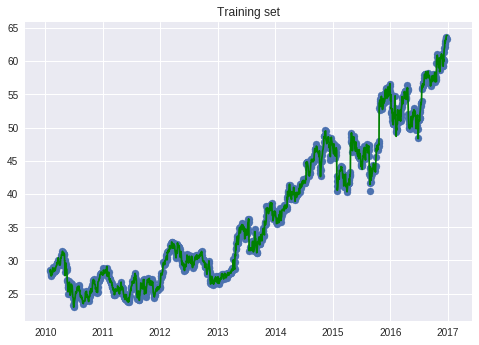

In [15]:
# solve for w (weights) on training data
w = np.linalg.solve(X_train.T.dot(X_train), X_train.T.dot(Y_train))
Y_train_hat = X_train.dot(w)
train_r_2 = get_r_squared(Y_train, Y_train_hat)
print('r_squared of training set is:', train_r_2)

train_dates = convert_numpy_dates_to_panda(dates[train_indexes])
plt.title('Training set')
plt.scatter(train_dates, Y_train)
plt.plot(train_dates, Y_train_hat, c='g')
plt.show()

r_squared of test set is: 0.9996452839301164


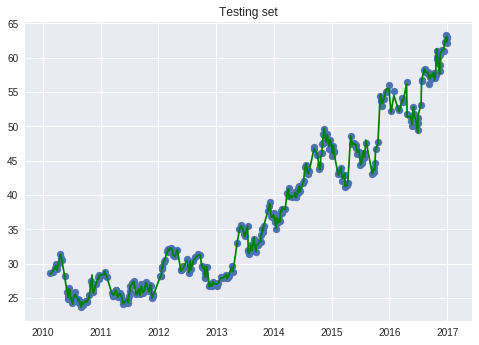

In [16]:
# use w from training data to predict values in test data
Y_test_hat = X_test.dot(w)
test_r_2 = get_r_squared(Y_test, Y_test_hat)
print('r_squared of test set is:', test_r_2)

test_dates = convert_numpy_dates_to_panda(dates[test_indexes])
plt.title('Testing set')
plt.scatter(test_dates, Y_test)
plt.plot(test_dates, Y_test_hat, c='g')
plt.show()